In [8]:
import niskine
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import mplniw.plot as pl

In [29]:
mooring = 2
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)
root_dir = '/Users/zcasparcohen/codes/NIW/'

In [30]:
gridded = xr.open_dataset(root_dir+'data/gridded/M%s_gridded_simple_merge_gaps_filled.nc'%mooring)

In [31]:
gridded

<xarray.Dataset>
Dimensions:       (z: 101, time: 73152, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-16T15:00:00 ... 2020-10-05T14...
  * z             (z) int64 0 16 32 48 64 80 ... 1520 1536 1552 1568 1584 1600
  * adcp          (adcp) int64 3110 10219 10185
Data variables:
    u             (z, time) float64 ...
    v             (z, time) float64 ...
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
Attributes:
    project:       NISKINe
    mooring:       M2
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

In [5]:
def ni_bandpass_adcp(adcp, bandwidth=1.06):
    tlow, thigh = niskine.calcs.determine_ni_band(bandwidth=1.06)
    outu = adcp.u.copy()
    outu = outu.interpolate_na(dim="time", max_gap=np.timedelta64(8, "h"))
    outv = adcp.v.copy()
    outv = outv.interpolate_na(dim="time", max_gap=np.timedelta64(8, "h"))
    i = 0
    for g, aai in outu.groupby("z"):
        outu[i, :] = niskine.calcs.bandpass_time_series(aai.data, tlow, thigh, fs=6)
        i += 1
    i = 0
    for g, aai in outv.groupby("z"):
        outv[i, :] = niskine.calcs.bandpass_time_series(aai.data, tlow, thigh, fs=6)
        i += 1
    adcp["bpu"] = outu
    adcp["bpv"] = outv
    return adcp
    
def calc_ni_eke(adcp):
    rho = 1025
    # load WKB normalization matrix
    wkb = niskine.clim.get_wkb_factors(adcp)
    # calculate NI EKE
    adcp["ni_eke"] = 0.5 * rho * ((wkb * adcp.bpu) ** 2 + (wkb * adcp.bpv) ** 2)
    return adcp,wkb

In [11]:
ds_filtered = ni_bandpass_adcp(gridded)
ds_filt,wkb = calc_ni_eke(ds_filtered)
ds_filt['ke'] = 0.5*(ds_filt.u**2+ds_filt.v**2)
ds_filt['eke'] = 0.5*((ds_filt.u-ds_filt.u.mean())**2+(ds_filt.v-ds_filt.v.mean())**2)
ds_filt['bpu_wkb'] = ds_filt['bpu']*wkb
ds_filt['bpv_wkb'] = ds_filt['bpv']*wkb

In [20]:
#MLD loading
mld_all = xr.open_dataset(conf.data.input.argo_mld)
mld_da = xr.DataArray(data=mld_all.mld_da_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='da')
mld_dt = xr.DataArray(data=mld_all.mld_dt_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='dt')
#Local MLD
mld = mld_da.sel(lon=lon,lat=lat,method='nearest')

(<Figure size 1500x500 with 3 Axes>, <Axes: xlabel='time', ylabel='depth [m]'>)

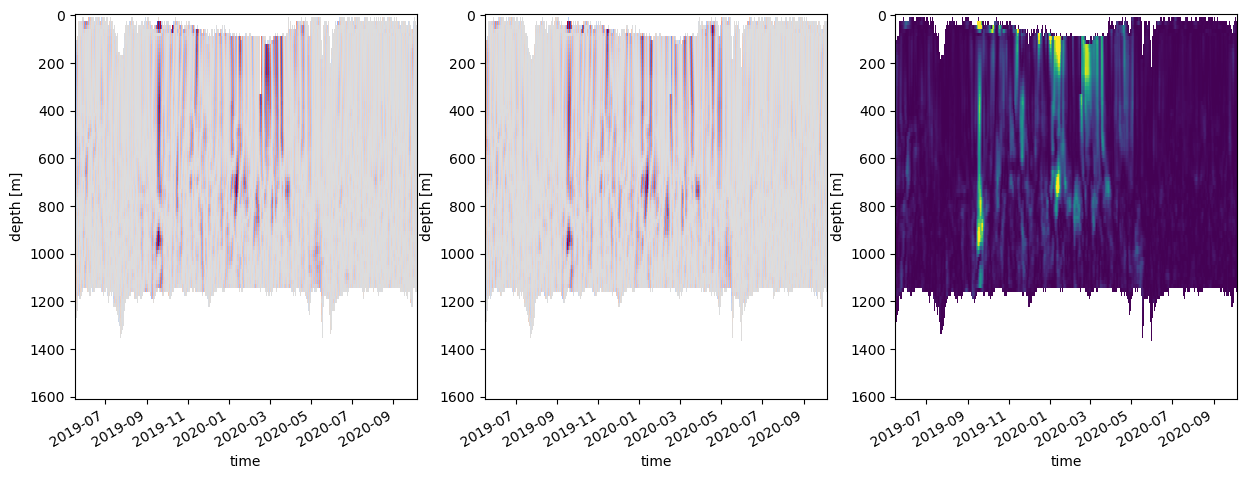

In [26]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
pl.plot_uv(ds_filt,'bpu_wkb',fig,ax,**{'vmax':0.08,'add_colorbar':False,'zorder':-1})
#ax.plot(mld.month,mld,zorder=1)
ax = fig.add_subplot(132)
pl.plot_uv(ds_filt,'bpv_wkb',fig,ax,**{'vmax':0.08,'add_colorbar':False})
ax = fig.add_subplot(133)
pl.plot_uv(ds_filt,'ni_eke',fig,ax,**{'vmax':4,'cmap':'viridis','add_colorbar':False})

In [42]:
ti = ['2019-09-10']
tf = ['2019-09-30']

(<Figure size 500x500 with 2 Axes>, <Axes: xlabel='time', ylabel='depth [m]'>)

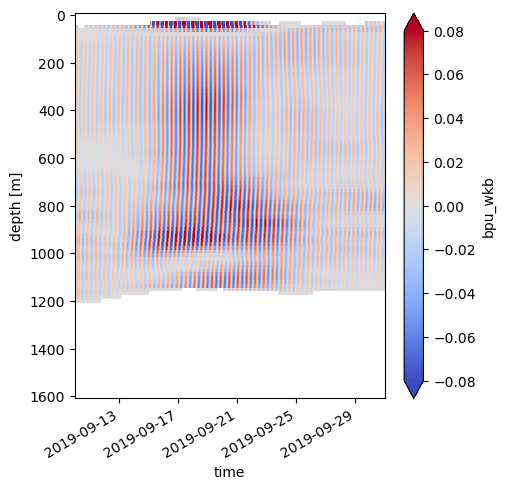

In [43]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
pl.plot_uv(ds_filt.sel(time=slice(ti[0],tf[0])),'bpu_wkb',fig,ax,**{'vmax':0.08})